<a href="https://colab.research.google.com/github/Azure06072005/DS317-Data-Mining-for-Enterprise/blob/main/reply_user_video_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import necessary libraries


In [2]:
from os import truncate
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import explode, col, array_max, split, sum

spark = SparkSession.builder \
  .appName("reply_user_video_analysis") \
  .master("local[*]") \
  .config("spark.some.config.option", "some-value") \
  .getOrCreate()

In [3]:
BASE_DIR = '/content/drive/MyDrive/Dataset'

In [4]:
!tree {BASE_DIR}

/bin/bash: line 1: tree: command not found


# Reply DataFrame

In [5]:
df_reply = spark.read.json(BASE_DIR + '/entities/reply.json')
df_reply.show(30, truncate=True)

+-------------------+-----+-------------------------------------+----------+
|        create_time|   id|                                 text|   user_id|
+-------------------+-----+-------------------------------------+----------+
|2019-08-05 12:55:54| Rp_1|                             测试回复|U_10030806|
|2019-08-09 16:39:06| Rp_2|                                   赞|U_10031397|
|2019-08-10 22:39:35| Rp_3|                               好喜欢|U_10031531|
|2019-08-12 14:43:34| Rp_4|                             你也好棒|U_10031508|
|2019-08-12 14:44:51| Rp_5|                                 嗯对|U_10031508|
|2019-08-12 14:47:58| Rp_6|                           人工智能是|U_10031508|
|2019-08-13 09:41:32| Rp_7|           我的观点就是，你说啥就时啥|U_10031536|
|2019-08-13 09:41:42| Rp_8|           我的观点就是，你说啥就时啥|U_10031536|
|2019-08-13 09:41:53| Rp_9|           我的观点就是，你说啥就时啥|U_10031536|
|2019-08-13 09:41:59|Rp_10|           我的观点就是，你说啥就时啥|U_10031536|
|2019-08-19 18:08:53|Rp_11|                                11111|U_100

In [6]:
df_reply.printSchema()

root
 |-- create_time: string (nullable = true)
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)



In [7]:
from pyspark.sql import functions as F
miss = df_reply.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c)
    for c in df_reply.columns
])

miss.show()

+-----------+---+----+-------+
|create_time| id|text|user_id|
+-----------+---+----+-------+
|          0|  0|   0|      0|
+-----------+---+----+-------+



In [8]:
df_reply.describe().show(truncate=False)

+-------+-------------------+--------+---------------------+----------+
|summary|create_time        |id      |text                 |user_id   |
+-------+-------------------+--------+---------------------+----------+
|count  |331011             |331011  |331011               |331011    |
|mean   |NULL               |NULL    |5.017241089215226E24 |NULL      |
|stddev |NULL               |NULL    |1.6686278219729687E26|NULL      |
|min    |2019-08-05 12:55:54|Rp_1    |!                    |U_10000657|
|max    |2020-11-15 03:56:04|Rp_99999|󠀋・ࡇ・              |U_9999609 |
+-------+-------------------+--------+---------------------+----------+



In [9]:
from pyspark.sql.functions import count

# Group by user_id and count the number of replies for each user
reply_counts = df_reply.groupBy("user_id").agg(count("text").alias("reply_count"))

# Order by reply_count in descending order and get the top 10
top_10_repliers = reply_counts.orderBy("reply_count", ascending=False).limit(10)

# Show the result
top_10_repliers.show()

+----------+-----------+
|   user_id|reply_count|
+----------+-----------+
|U_12137387|      22477|
| U_3558829|      11773|
|U_15053528|      10013|
|U_10842547|       8291|
| U_9741717|       5796|
|U_10238951|       4811|
|U_10842580|       3804|
| U_8264065|       3773|
|U_15092855|       3293|
|U_15092062|       3249|
+----------+-----------+



/tmp/ipython-input-568307334.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


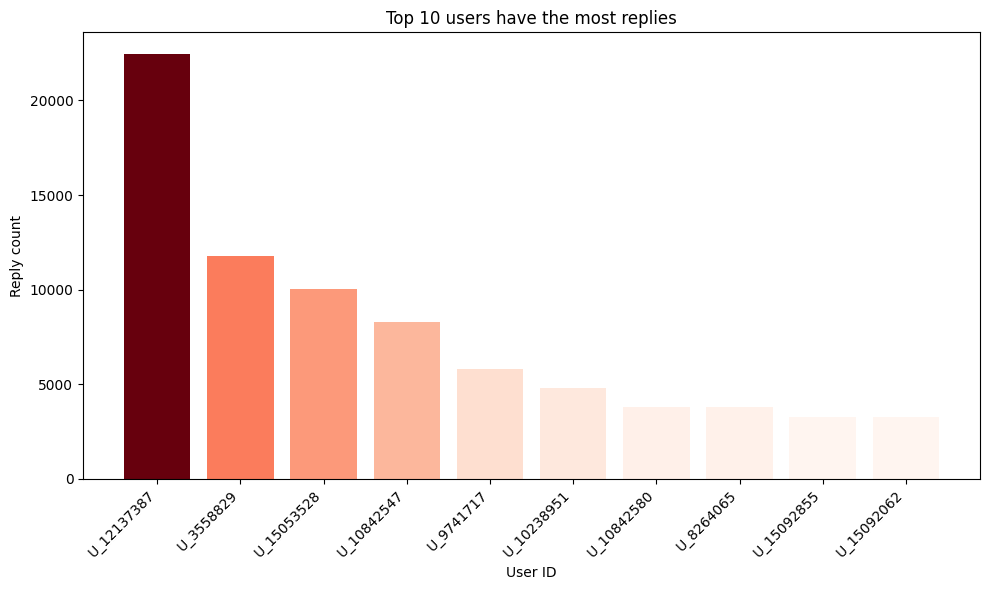

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

top_10_repliers_list = top_10_repliers.collect()

user_ids = [row['user_id'] for row in top_10_repliers_list]
reply_counts = [row['reply_count'] for row in top_10_repliers_list]

# Create a colormap and normalize the colors based on reply count
cmap = cm.get_cmap('Reds')
normalize = plt.Normalize(min(reply_counts), max(reply_counts))
colors = [cmap(normalize(count)) for count in reply_counts]


plt.figure(figsize=(10, 6))
plt.bar(user_ids, reply_counts, color=colors)
plt.xlabel("User ID")
plt.ylabel("Reply count")
plt.title("Top 10 users have the most replies")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

+-----------------+------------------+
|             mean|            stddev|
+-----------------+------------------+
|6.579035239401348|146.41203644703566|
+-----------------+------------------+

25th percentile (Q1): 1.0
50th percentile (Median): 1.0
75th percentile (Q3): 2.0


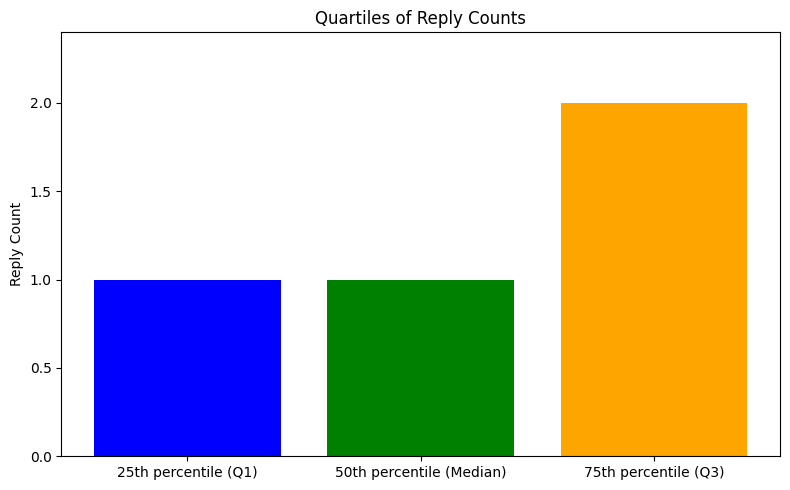

In [11]:
from pyspark.sql.functions import count, mean, stddev, percentile_approx

# Group by user_id and count the number of replies for each user (re-creating reply_counts DataFrame)
reply_counts = df_reply.groupBy("user_id").agg(count("text").alias("reply_count"))

# Calculate mean and standard deviation of reply counts from the DataFrame
mean_stddev = reply_counts.agg(mean("reply_count").alias("mean"),
                                 stddev("reply_count").alias("stddev"))
mean_stddev.show()

# Calculate quartiles (25%, 50%, 75%) of reply counts from the DataFrame
quantiles = reply_counts.approxQuantile("reply_count", [0.25, 0.5, 0.75], 0.01)

# Extract quartile values
q1 = quantiles[0]
median = quantiles[1]
q3 = quantiles[2]

print(f"25th percentile (Q1): {q1}")
print(f"50th percentile (Median): {median}")
print(f"75th percentile (Q3): {q3}")

# Prepare data for plotting quartiles
labels = ['25th percentile (Q1)', '50th percentile (Median)', '75th percentile (Q3)']
values = [q1, median, q3]

# Create a bar plot for quartiles
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'green', 'orange'])
plt.ylabel('Reply Count')
plt.title('Quartiles of Reply Counts')
plt.ylim(0, max(values) * 1.2) # Adjust y-axis limit for better visualization
plt.tight_layout()
plt.show()

In [12]:
df_user_video = spark.read.parquet(BASE_DIR + '/relations/user-video/user-video-seg*.parquet')
df_user_video.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
df_user_video.describe().show()

+-------+----------+
|summary|   user_id|
+-------+----------+
|  count|    310360|
|   mean|      NULL|
| stddev|      NULL|
|    min|U_10001181|
|    max| U_9999820|
+-------+----------+



# Tách dữ liệu từ cột seq

In [14]:
from os import truncate
from pyspark.sql.functions import explode
# Explode the outer array in 'seq' to get each video sequence as a row
df_exploded = df_user_video.select("user_id", explode("seq").alias("video_sequence"))
# Select the video_id and explode the 'segment' array within each video sequence
df_exploded = df_exploded.select(
    "user_id",
    df_exploded["video_sequence"]["video_id"].alias("video_id"),
    explode(df_exploded["video_sequence"]["segment"]).alias("segment_details")
)
# Select the individual fields from the 'segment_details' struct
df_flattened = df_exploded.select(
    "user_id",
    "video_id",
    df_exploded["segment_details"]["start_point"].alias("start_point"),
    df_exploded["segment_details"]["end_point"].alias("end_point"),
    df_exploded["segment_details"]["speed"].alias("speed"),
    df_exploded["segment_details"]["local_start_time"].alias("local_start_time")
    )
# Show the resulting DataFrame with separated columns
df_flattened.show(truncate=False)

+---------+---------+-----------+---------+-----+----------------+
|user_id  |video_id |start_point|end_point|speed|local_start_time|
+---------+---------+-----------+---------+-----+----------------+
|U_7329543|V_1404465|4.8        |164.9    |1.0  |1598177594      |
|U_7329543|V_1404469|572.4      |587.4    |1.0  |1598181080      |
|U_7329543|V_1404470|34.8       |54.8     |1.0  |1598181866      |
|U_7329543|V_1404470|52.2       |55.9     |1.0  |1598181962      |
|U_7329543|V_1404471|4.8        |182.5    |1.0  |1598181976      |
|U_7329543|V_1404472|4.8        |34.9     |1.0  |1598182171      |
|U_7329543|V_1404472|64.9       |99.5     |1.0  |1598182231      |
|U_7329543|V_1404473|6.9        |90.3     |2.0  |1598182329      |
|U_7329543|V_1404493|4.8        |44.9     |1.0  |1598265546      |
|U_7329543|V_1404493|75.9       |84.3     |1.0  |1598265880      |
|U_7329543|V_1404494|4.8        |19.9     |1.0  |1598265901      |
|U_7329543|V_1404494|18.4       |43.4     |1.0  |1598265938   

In [15]:
df_video = spark.read.json(BASE_DIR + '/entities/video.json')
df_video.printSchema()
df_video.show(1, truncate=True)

root
 |-- ccid: string (nullable = true)
 |-- end: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- name: string (nullable = true)
 |-- start: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- text: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------------------+--------------------+-----+--------------------+------------------------------------+
|                ccid|                 end| name|               start|                                text|
+--------------------+--------------------+-----+--------------------+------------------------------------+
|0001603F826A3DDA9...|[4.255, 8.119, 10...|Video|[1.031, 7.095, 8....|[第二个就是短助记符在生成上面。有...|
+--------------------+--------------------+-----+--------------------+------------------------------------+
only showing top 1 row



In [16]:
df_course = spark.read.json(BASE_DIR + '/entities/course.json')
df_course.printSchema()
df_course.show(1, truncate=True)

root
 |-- about: string (nullable = true)
 |-- field: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- prerequisites: string (nullable = true)
 |-- resource: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- chapter: string (nullable = true)
 |    |    |-- resource_id: string (nullable = true)
 |    |    |-- titles: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)

+-------------------------------------+----------------------+--------+----------------+-------------+--------------------+
|                                about|                 field|      id|            name|prerequisites|            resource|
+-------------------------------------+----------------------+--------+----------------+-------------+--------------------+
|通过老师导读，同学们可深入这一经典...|[历史学, 中国语言文学]|C_584313|《资治通鉴》导读|             |[{1.1.1, V_849, [...|
+-

In [17]:
# Course -> Video
from pyspark.sql.functions import col
df_course_video = df_course.select(
    col("id").alias("course_id"),
    explode("resource").alias("resource")
).filter(
    col("resource.resource_id").like("V_%")
).select(
    "course_id",
    col("resource.resource_id").alias("video_id")
)

df_course_video.show(5, truncate=False)

+---------+--------+
|course_id|video_id|
+---------+--------+
|C_584313 |V_849   |
|C_584313 |V_850   |
|C_584313 |V_851   |
|C_584313 |V_857   |
|C_584313 |V_859   |
+---------+--------+
only showing top 5 rows



In [18]:
from pyspark.sql.functions import array_max

df_video_duration = df_video.select(
    col("ccid"),
    array_max("end").alias("video_duration")
)
df_video_duration.show(5, truncate=False)

+--------------------------------+--------------+
|ccid                            |video_duration|
+--------------------------------+--------------+
|0001603F826A3DDA9C33DC5901307461|509.095       |
|0003DB14A14A53279C33DC5901307461|367.336       |
|0004A5C6F07E369D9C33DC5901307461|492.315       |
|00059EBD1371A6959C33DC5901307461|630.757       |
|0005D1DC01B4EF8F9C33DC5901307461|408.75        |
+--------------------------------+--------------+
only showing top 5 rows



# Video_id-ccid

In [19]:
df_video_id_ccid = spark.read.text(BASE_DIR + '/relations/video_id-ccid.txt')
df_video_id_ccid.show(truncate=False)

+-------------------------------------------+
|value                                      |
+-------------------------------------------+
|V_234845\t0000363DB5B6E0869C33DC5901307461 |
|V_234876\t0000363DB5B6E0869C33DC5901307461 |
|V_234907\t0000363DB5B6E0869C33DC5901307461 |
|V_293392\t0000363DB5B6E0869C33DC5901307461 |
|V_293445\t0000363DB5B6E0869C33DC5901307461 |
|V_293494\t0000363DB5B6E0869C33DC5901307461 |
|V_627142\t0000363DB5B6E0869C33DC5901307461 |
|V_944346\t0000363DB5B6E0869C33DC5901307461 |
|V_944377\t0000363DB5B6E0869C33DC5901307461 |
|V_944408\t0000363DB5B6E0869C33DC5901307461 |
|V_1386166\t0000363DB5B6E0869C33DC5901307461|
|V_1479635\t0000363DB5B6E0869C33DC5901307461|
|V_1494506\t0000363DB5B6E0869C33DC5901307461|
|V_1494536\t0000363DB5B6E0869C33DC5901307461|
|V_1494566\t0000363DB5B6E0869C33DC5901307461|
|V_1494614\t0000363DB5B6E0869C33DC5901307461|
|V_1494625\t0000363DB5B6E0869C33DC5901307461|
|V_1494656\t0000363DB5B6E0869C33DC5901307461|
|V_1570352\t0000363DB5B6E0869C33DC

In [20]:
from pyspark.sql.functions import split

df_video_id_ccid = df_video_id_ccid.select(
    split(col("value"), "\t")[0].alias("video_id"),
    split(col("value"), "\t")[1].alias("ccid")
)

df_video_id_ccid.show(5, truncate=False)

+--------+--------------------------------+
|video_id|ccid                            |
+--------+--------------------------------+
|V_234845|0000363DB5B6E0869C33DC5901307461|
|V_234876|0000363DB5B6E0869C33DC5901307461|
|V_234907|0000363DB5B6E0869C33DC5901307461|
|V_293392|0000363DB5B6E0869C33DC5901307461|
|V_293445|0000363DB5B6E0869C33DC5901307461|
+--------+--------------------------------+
only showing top 5 rows



In [21]:
from pyspark.sql.functions import col, sum, when, broadcast

# Bước 1: Tính toán và gom nhóm trên DataFrame lớn nhất (df_flattened) trước tiên.
# Điều này sẽ thu nhỏ đáng kể kích thước dữ liệu trước khi join.
df_watched_agg = df_flattened \
    .withColumn("watched_duration", col("end_point") - col("start_point")) \
    .groupBy("user_id", "video_id") \
    .agg(sum("watched_duration").alias("total_watched"))

# Bước 2: Nối (join) kết quả đã gom nhóm với các DataFrame thông tin (dimension tables).
# Sử dụng broadcast join cho các DataFrame nhỏ để tối ưu hiệu năng.
# broadcast() sẽ gửi một bản sao của DataFrame nhỏ đến tất cả các executor, tránh việc shuffle DataFrame lớn.
df_final = df_watched_agg \
    .join(df_video_id_ccid, "video_id") \
    .join(broadcast(df_video_duration), "ccid") \
    .join(df_course_video, "video_id") \
    .withColumn(
        "watch_percentage",
        # Thêm điều kiện để tránh lỗi chia cho 0
        when(col("video_duration") > 0, (col("total_watched") / col("video_duration")) * 100)
        .otherwise(0) # Hoặc .otherwise(None) tùy vào logic bạn muốn
    ) \
    .select("course_id", "user_id", "video_id", "video_duration", "total_watched", "watch_percentage") # Sắp xếp lại các cột cho đẹp

# Hiển thị kết quả
df_final.show()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pyspark/errors/exceptions/captured.py", line 179, in deco
    return f(*a, **kw)
           ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/py4j/protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <exception str() failed>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^

Py4JError: py4j.reflection does not exist in the JVM